In [1]:
import healpy as h
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
from modules.settings import global_mmf_settings as gset
from modules.data_preprocess import preprocess_planck_data as ppd
from modules.masking import gen_masks
from modules.master import binned_master as bm
from copy import copy,deepcopy
%pylab notebook
figpath="../../../../joint_tsz_cnc/figs/"
datapath="../../tempdata/misc_data/"

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Initialising the analysis

In [2]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"

figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cosmo_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)

# Reading in the MMF3 catalogue

In [3]:
mmf3=ppd.get_mmf3_catalogue(zknown=False,snrthr=6.,cosmo_flag=True)
mmf3=ppd.eval_M500_T500_theta500(mmf3)
median_theta500=median(mmf3["theta500"][mmf3["REDSHIFT"]>0])
mmf3["theta500"][[mmf3["REDSHIFT"]<0]]=median_theta500
shape(mmf3["REDSHIFT"])

/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF/analysis/modules/cosmology/cosmo_fn.py:26: RuntimeWarning: divide by zero encountered in divide
  return d0(z)/(1.+z)
/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF/analysis/modules/cosmology/cosmo_fn.py:62: RuntimeWarning: invalid value encountered in multiply
  y=rhs*(500./dA(z))


(439,)

# Generate point source mask
- The point source mask is generated at the full resolution of NSIDE=2048. Only after multiplying with the galactic mask is the final mask degraded to a lower resolution of NSIDE=512 for the spectral analysis.

In [4]:
gset.mmfset.ps_mask_weights[30.]=1.
gset.mmfset.ps_mask_weights[40.]=1.
gset.mmfset.ps_mask_weights[70.]=1.
print gset.mmfset.ps_mask_weights
psmask=ppd.gen_ps_mask(snrthr=5.,ps_cutoff=5.)

{353.0: 1.0, 100.0: 1.0, 70.0: 1.0, 545.0: 1.0, 40.0: 1.0, 44.0: 0.0, 143.0: 1.0, 857.0: 1.0, 217.0: 1.0, 30.0: 1.0}


# Read in the MILCA and NILC y-maps and downgrade to speed up spectral analysis

In [5]:
do_dgrade=True ; nsideout=2048
fname="/Users/adityarotti/Documents/Work/Data/Planck/maps/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits"
gmask=h.read_map(fname,1,verbose=False)
mask=gmask*psmask

fname="/Users/adityarotti/Documents/Work/Data/Planck/maps/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits"
nilc=h.read_map(fname,0,verbose=False)
nilc_f=h.read_map(fname,1,verbose=False)
nilc_l=h.read_map(fname,2,verbose=False)

fname="/Users/adityarotti/Documents/Work/Data/Planck/maps/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits"
milca=h.read_map(fname,0,verbose=False)
milca_f=h.read_map(fname,1,verbose=False)
milca_l=h.read_map(fname,2,verbose=False)


if do_dgrade:
    mask=h.ud_grade(mask,nsideout) ; mask[mask>=0.5]=1. ; mask[mask<0.5]=0.
    gmask=h.ud_grade(gmask,nsideout) ; gmask[gmask>=0.5]=1. ; gmask[gmask<0.5]=0.
    nilc=h.ud_grade(nilc,nsideout)
    nilc_f=h.ud_grade(nilc_f,nsideout)
    nilc_l=h.ud_grade(nilc_l,nsideout)
    milca=h.ud_grade(milca,nsideout)
    milca_f=h.ud_grade(milca_f,nsideout)
    milca_l=h.ud_grade(milca_l,nsideout)

nside=h.get_nside(mask)
print nside

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


2048


# Generate the cluster mask. 
- The VIRGO and COMA mask are generated separately as the prescription used to evaluate the
size of the mask for other clusters does not fully mask these clusters, especially VIRGO.


In [6]:
virgo_mask=np.ones_like(mask)
virgo_glon=279.6763 ; virgo_glat=74.4596
pixcs=h.ang2pix(nside,virgo_glon,virgo_glat,lonlat=True) ; vec=h.pix2vec(nside,pixcs)
radius=3.*np.pi/180.
disc_pix=h.query_disc(nside,vec,radius=radius,fact=4,inclusive=True)
virgo_mask[disc_pix]=0.0

coma_mask=np.ones_like(mask)
coma_glon=058.0791 ; coma_glat=87.9577
pixcs=h.ang2pix(nside,coma_glon,coma_glat,lonlat=True) ; vec=h.pix2vec(nside,pixcs)
radius=3.*np.pi/180.
disc_pix=h.query_disc(nside,vec,radius=radius,fact=4,inclusive=True)
coma_mask[disc_pix]=0.0

#h.orthview(virgo_mask,rot=(0,90))

clmask=np.ones_like(mask)
pixcs=h.ang2pix(nside,mmf3["GLON"],mmf3["GLAT"],lonlat=True)
radius=5.*(mmf3["theta500"]/60.)*np.pi/180.
for i,pix in enumerate(pixcs):
    vec=h.pix2vec(nside,pix)
    disc_pix=h.query_disc(nside,vec,radius=radius[i],fact=4,inclusive=True)
    clmask[disc_pix]=0.0
    
clmask=clmask*virgo_mask*coma_mask

filename=datapath + "gal_ps_mask.fits"
h.write_map(filename,mask,overwrite=True)

filename=datapath + "gal_ps_cl_mask.fits"
h.write_map(filename,mask*clmask,overwrite=True)

filename=datapath + "gal_ps_ccl_mask.fits"
h.write_map(filename,mask*(1.-clmask),overwrite=True)

In [7]:
fsky_tot=sum(mask)/size(mask)
fsky_diff=sum(mask*clmask)/size(mask)
fsky_res=sum(mask*(1.-clmask))/size(mask)
print fsky_tot,fsky_diff,fsky_res

0.429107189178 0.416240473588 0.0128667155902


# Reading in the apodized masks.
- **Remember that the apodization code needs to be rerun if the mask has changed.**

In [8]:
gal_ps_mask=h.read_map("../../tempdata/misc_data/gal_ps_mask_apo_fh0a_apo30a.fits",verbose=False)
gal_ps_cl_mask=h.read_map("../../tempdata/misc_data/gal_ps_cl_mask_apo_fh0a_apo30a.fits",verbose=False)
gal_ps_ccl_mask=h.read_map("../../tempdata/misc_data/gal_ps_ccl_mask_apo_fh0a_apo30a.fits",verbose=False)

In [9]:
# gal_ps_mask=np.copy(mask)
# gal_ps_cl_mask=mask*clmask
# gal_ps_ccl_mask=mask*(1-clmask)

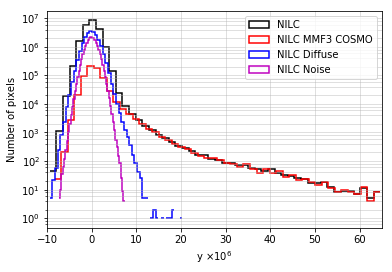

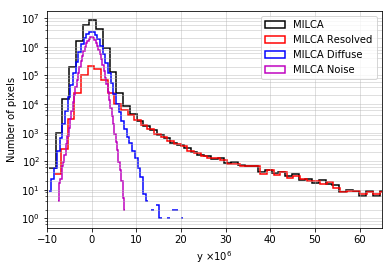

In [10]:
figure()
a,b,c=hist(nilc[mask!=0]*1e6,histtype="step",bins=50,normed=False,label="NILC",lw=1.5,color="k")
a,b,c=hist(nilc[mask*(1-clmask)!=0]*1e6,histtype="step",bins=50,normed=False,label="NILC MMF3 COSMO",lw=1.5,color="r")
a,b,c=hist(nilc[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="NILC Diffuse",lw=1.5,color="b")
a,b,c=hist(((nilc_f-nilc_l)/2.)[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="NILC Noise",lw=1.5,color="m")
semilogy()
legend(loc=0)
#ylim(1e-6,0.5)
xlim(-10,65)
grid(alpha=0.5,which="both")
figname=figpath + "y_nilc_histogram.pdf"
xlabel(r"y $\times 10^6$")
ylabel("Number of pixels")
savefig(figname,bbox_inches="tight")

figure()
a,b,c=hist(milca[mask!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA",lw=1.5,color="k")
a,b,c=hist(milca[mask*(1-clmask)!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA Resolved",lw=1.5,color="r")
a,b,c=hist(milca[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA Diffuse",lw=1.5,color="b")
a,b,c=hist(((milca_f-milca_l)/2.)[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA Noise",lw=1.5,color="m")
semilogy()
legend(loc=0)
#ylim(1e-6,0.5)
xlim(-10,65)
grid(alpha=0.5,which="both")
figname=figpath + "y_milca_histogram.pdf"
xlabel(r"y $\times 10^6$")
ylabel("Number of pixels")
savefig(figname,bbox_inches="tight")

# Generate map figures

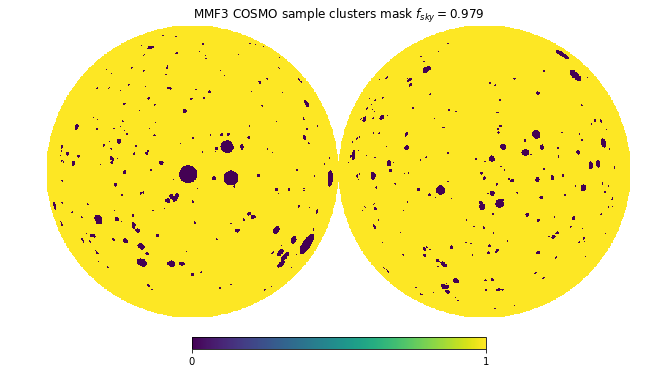

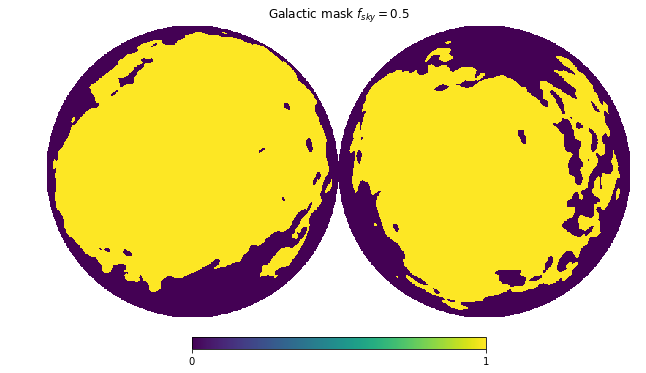

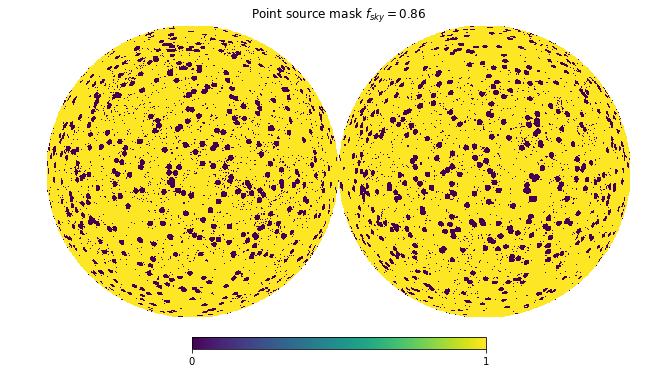

In [11]:
fsky=sum(clmask)/size(gmask)
h.orthview(clmask,rot=(0,90),title="MMF3 COSMO sample clusters mask $f_{sky}=" + str(round(fsky,3)) + "$")
figname=figpath + "cluster_mask.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(gmask)/size(gmask)
h.orthview(gmask,rot=(0,90),title="Galactic mask $f_{sky}=" + str(round(fsky,3)) + "$")
figname=figpath + "gal_mask.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(psmask)/size(psmask)
h.orthview(psmask,rot=(0,90),title="Point source mask $f_{sky}=" + str(round(fsky,3)) + "$")
figname=figpath + "ps_mask.pdf"
savefig(figname,bbox_inches="tight")

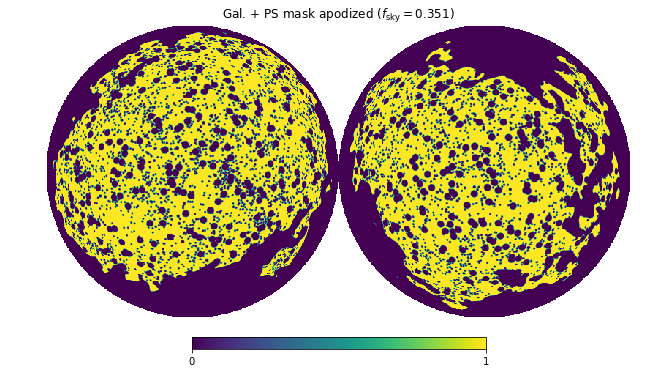

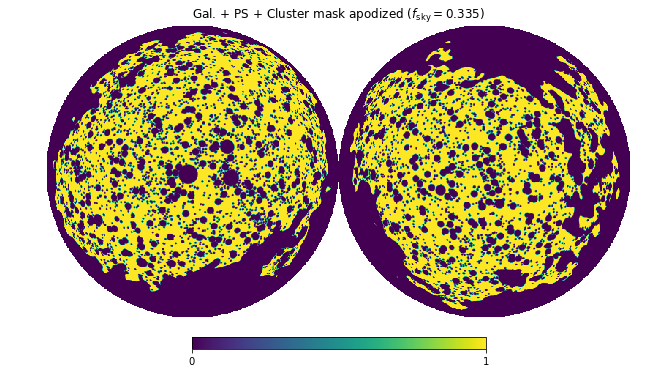

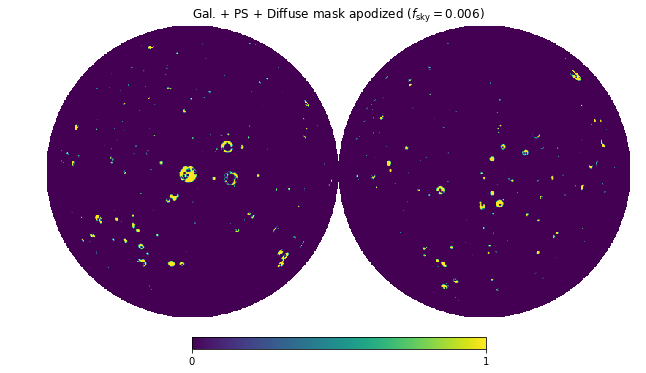

In [12]:
fsky=sum(gal_ps_mask)/size(gal_ps_mask)
h.orthview(gal_ps_mask,rot=(0,90),title=r"Gal. + PS mask apodized $(f_{\rm sky}=" + str(round(fsky,3)) + ")$")
figname=figpath + "gal_ps_mask_apo.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(gal_ps_cl_mask)/size(gal_ps_mask)
h.orthview(gal_ps_cl_mask,rot=(0,90),title=r"Gal. + PS + Cluster mask apodized $(f_{\rm sky}=" + str(round(fsky,3)) + ")$")
figname=figpath + "gal_ps_cl_mask_apo.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(gal_ps_ccl_mask)/size(gal_ps_mask)
h.orthview(gal_ps_ccl_mask,rot=(0,90),title=r"Gal. + PS + Diffuse mask apodized $(f_{\rm sky}=" + str(round(fsky,3)) + ")$")
figname=figpath + "gal_ps_ccl_mask_apo.pdf"
savefig(figname,bbox_inches="tight")

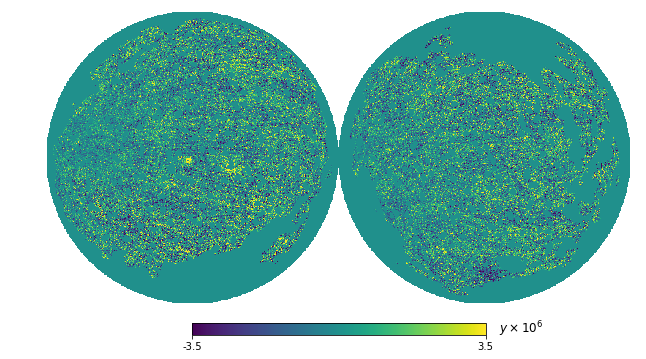

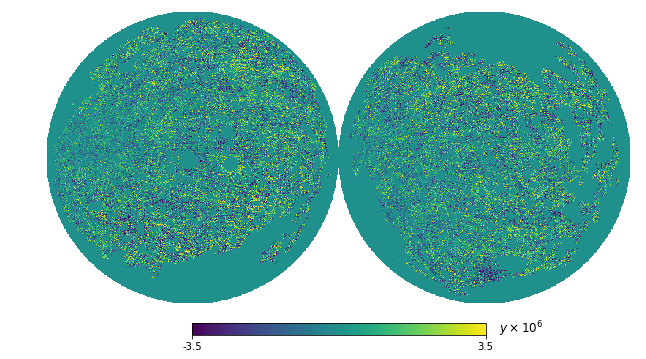

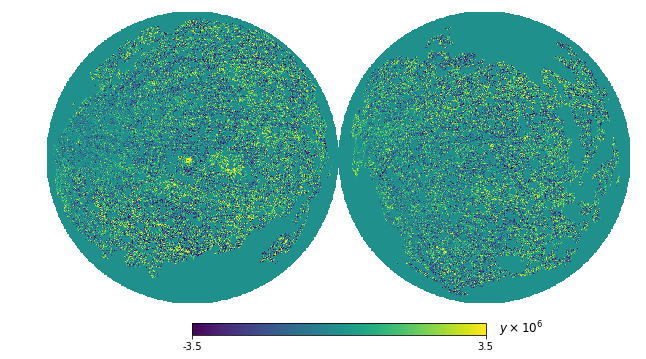

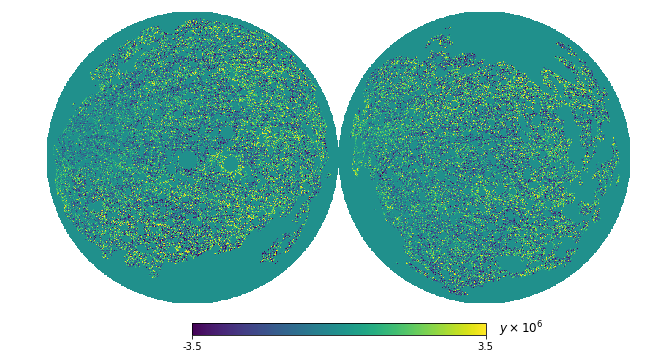

In [13]:
h.orthview(nilc*mask*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "nilc_before_clmask.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(nilc*clmask*mask*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "nilc_after_clmask.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(milca*mask*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "milca_before_clmask.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(milca*clmask*mask*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "milca_after_clmask.pdf"
savefig(figname,bbox_inches="tight")

# Power spectrum analysis

In [14]:
lmax=1500

# Total
tmask=gal_ps_mask ; fsky_tot_apo=sum(tmask)/size(tmask)
nilc_milca_tot=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))
nilc_hm1_tot=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_f*tmask,lmax=lmax))
milca_hm2_tot=h.alm2cl(h.map2alm(milca_l*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))
#nilc_tot=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_l*tmask,lmax=lmax))
#milca_tot=h.alm2cl(h.map2alm(milca_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))

# Diffuse
tmask=gal_ps_cl_mask ; fsky_diff_apo=sum(tmask)/size(tmask)
nilc_milca_diff=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))
nilc_hm1_diff=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_f*tmask,lmax=lmax))
milca_hm2_diff=h.alm2cl(h.map2alm(milca_l*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))
#nilc_diff=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_l*tmask,lmax=lmax))
#milca_diff=h.alm2cl(h.map2alm(milca_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))

# Resolved
tmask=gal_ps_ccl_mask ; fsky_res_apo=sum(tmask)/size(tmask)
nilc_milca_res=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))
nilc_hm1_res=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_f*tmask,lmax=lmax))
milca_hm2_res=h.alm2cl(h.map2alm(milca_l*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))
#nilc_res=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_l*tmask,lmax=lmax))
#milca_res=h.alm2cl(h.map2alm(milca_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))

In [16]:
planckyy=np.loadtxt("/Users/adityarotti/Documents/Work/Data/Planck/maps/planck2015_yy_ps.txt")
bmin=planckyy[:,3]
bmax=planckyy[:,4]

# Data from Boris's papers
planck_yy=np.loadtxt("/Users/adityarotti/Documents/Work/Data/Planck/maps/bolliet2018.txt")

In [17]:
masklmax=2*nside
beam=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=lmax)*h.pixwin(nside)[:lmax+1]
mtot=bm.binned_master(gal_ps_mask,2,lmax,masklmax,beam=beam,bmin=bmin,bmax=bmax)
#mres=bm.binned_master(gal_ps_mask,2,lmax,masklmax,beam=beam)
mres=deepcopy(mtot)
mdiff=bm.binned_master(gal_ps_cl_mask,2,lmax,masklmax,beam=beam,bmin=bmin,bmax=bmax)
#mdiff=deepcopy(mtot)

## Galactic mask + point source mask

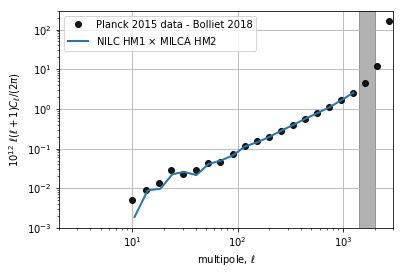

In [18]:
lbin,m_nilc_milca_tot=mtot.return_bmcs(nilc_milca_tot)
lbin,m_nilc_hm1_tot=mtot.return_bmcs(nilc_hm1_tot)
lbin,m_milca_hm2_tot=mtot.return_bmcs(milca_hm2_tot)
#lbin,m_nilc_tot=mtot.return_bmcs(nilc_tot)
#lbin,m_milca_tot=mtot.return_bmcs(milca_tot)


ell=arange(lmax+1)
bl=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=lmax)
pwc=h.pixwin(nside)[:lmax+1]
bl=bl*pwc
fl=ell*(ell+1)*1e12/(2.*pi)/bl/bl

figure()
plot(planck_yy[:,0],planck_yy[:,1],"ko",lw=2,label="Planck 2015 data - Bolliet 2018",alpha=0.9,ms=6)
plot(lbin,m_nilc_milca_tot*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2")
#plot(lbin,m_nilc_tot*1e12,lw=2,label=r"NILC : HM1 $\times$ HM2")
#plot(lbin,m_milca_tot*1e12,lw=2,label=r"MILCA : HM1 $\times$ HM2")
#plot(d[:,0],d[:,2],"r-",lw=2,label="Planck 2015 best fit")
#plot(d[:,0],d[:,1],"k-o",lw=2,label="Planck 2015 data",alpha=0.7)


loglog()
legend(loc=0)
grid()
xlim(2,3e3)
ylim(1e-3,3e2)
#ylim(2e-4,4)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_gal_ps_mask.pdf"
savefig(figname,bbox_inches="tight")

## Galactic mask + point source mask + cluster mask

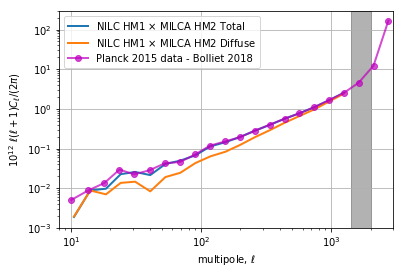

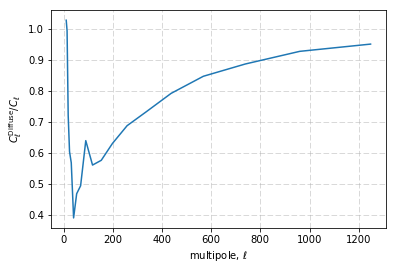

In [19]:
lbin,m_nilc_milca_diff=mdiff.return_bmcs(nilc_milca_diff)
lbin,m_nilc_hm1_diff=mdiff.return_bmcs(nilc_hm1_diff)
lbin,m_milca_hm2_diff=mdiff.return_bmcs(milca_hm2_diff)
#lbin,m_nilc_diff=mdiff.return_bmcs(nilc_diff)
#lbin,m_milca_diff=mdiff.return_bmcs(milca_diff)

figure()
plot(lbin,m_nilc_milca_tot*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Total")
plot(lbin,m_nilc_milca_diff*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Diffuse")
#plot(d[:,0],d[:,2],"r-",label="Planck 2015 best fit")
#plot(d[:,0],d[:,1],"k-o",label="Planck 2015 data",alpha=0.7)
plot(planck_yy[:,0],planck_yy[:,1],"m-o",lw=2,label="Planck 2015 data - Bolliet 2018",alpha=0.7)
loglog()
legend(loc=0)
grid()
#xlim(8,3e3)
#ylim(4e-3,3e2)
xlim(8,3e3)
ylim(1e-3,3e2)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_compare_diffuse_vs_total.pdf"
savefig(figname,bbox_inches="tight")

figure()
plot(lbin,m_nilc_milca_diff/m_nilc_milca_tot)
xlabel(r"multipole, $\ell$")
ylabel(r"$C^{\rm Diffuse}_{\ell}/C_{\ell}$")
grid(alpha=0.6,linestyle="dashed")
figname=figpath + "ratio_cldiffuse_by_cltotal.pdf"
savefig(figname,bbox_inches="tight")

## Galactic mask + point source mask + cluster mask complement

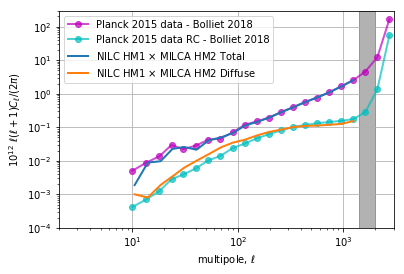

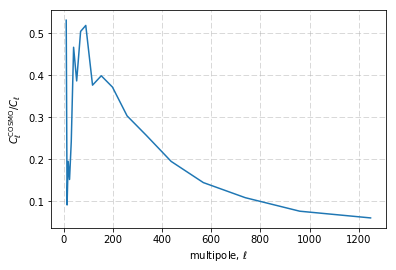

In [20]:
lbin,m_nilc_milca_res=mtot.return_bmcs(nilc_milca_res)
lbin,m_nilc_hm1_res=mtot.return_bmcs(nilc_hm1_res)
lbin,m_milca_hm2_res=mtot.return_bmcs(milca_hm2_res)
#lbin,m_nilc_res=mres.return_bmcs(nilc_res)
#lbin,m_milca_res=mres.return_bmcs(milca_res)


tmpell=arange(lmax+1)
figure()
plot(planck_yy[:,0],planck_yy[:,1],"m-o",lw=2,label="Planck 2015 data - Bolliet 2018",alpha=0.7)
plot(planck_yy[:,0],planck_yy[:,3],"c-o",lw=2,label="Planck 2015 data RC - Bolliet 2018",alpha=0.7)
plot(lbin,m_nilc_milca_tot*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Total")
plot(lbin,m_nilc_milca_res*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Diffuse")
# plot(lbin,m_milca_hm2_res*1e12)
# plot(lbin,m_nilc_hm1_res*1e12)
#plot(tmpell,tmpell*(tmpell+1.)*nilc_milca_res*1e12/(2.*pi*fsky_tot*beam*beam))
loglog()
legend(loc=0)
grid()
#semilogx()
xlim(2,3e3)
#ylim(1e-4,50)
ylim(1e-4,3e2)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_compare_cosmo_vs_total.pdf"
savefig(figname,bbox_inches="tight")

figure()
plot(lbin,m_nilc_milca_res/m_nilc_milca_tot)
xlabel(r"multipole, $\ell$")
ylabel(r"$C^{\rm COSMO}_{\ell}/C_{\ell}$")
grid(alpha=0.6,linestyle="dashed")
figname=figpath + "ratio_clresolved_by_cltotal.pdf"
savefig(figname,bbox_inches="tight")

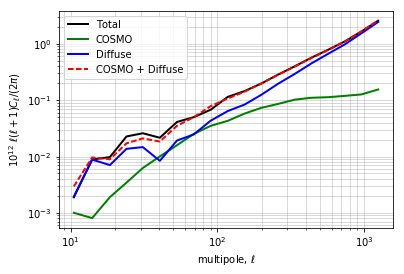

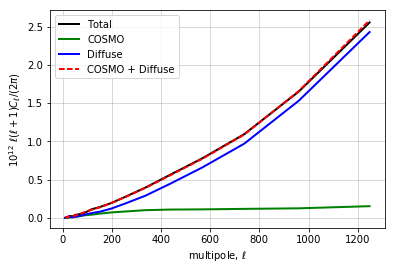

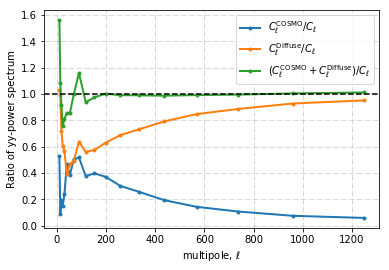

In [21]:
figure()
plot(lbin,m_nilc_milca_tot*1e12,"k-",lw=2,label=r"Total")
plot(lbin,m_nilc_milca_res*1e12,"g-",lw=2,label=r"COSMO")
plot(lbin,m_nilc_milca_diff*1e12,"b-",lw=2,label=r"Diffuse")
plot(lbin,(m_nilc_milca_res+m_nilc_milca_diff)*1e12,"r--",lw=2,label=r"COSMO + Diffuse")
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
grid(which="both",alpha=0.6,linestyle="solid")
legend(loc=0)
loglog()
figname=figpath + "test_spectra_additive.pdf"
savefig(figname,bbox_inches="tight")

figure()
plot(lbin,m_nilc_milca_tot*1e12,"k-",lw=2,label=r"Total")
plot(lbin,m_nilc_milca_res*1e12,"g-",lw=2,label=r"COSMO")
plot(lbin,m_nilc_milca_diff*1e12,"b-",lw=2,label=r"Diffuse")
plot(lbin,(m_nilc_milca_res+m_nilc_milca_diff)*1e12,"r--",lw=2,label=r"COSMO + Diffuse")
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
grid(which="both",alpha=0.6,linestyle="solid")
legend(loc=0)
#semilogx()
#ylim(0,0.05)
figname=figpath + "test_spectra_additive_linear.pdf"
savefig(figname,bbox_inches="tight")

figure()
plot(lbin,m_nilc_milca_res/m_nilc_milca_tot,".-",lw=2,label=r"$C^{\rm COSMO}_{\ell}/C_{\ell}$")
plot(lbin,m_nilc_milca_diff/m_nilc_milca_tot,".-",lw=2,label=r"$C^{\rm Diffuse}_{\ell}/C_{\ell}$")
plot(lbin,(m_nilc_milca_diff + m_nilc_milca_res)/m_nilc_milca_tot,".-",lw=2,label=r"$(C^{\rm COSMO}_{\ell} + C^{\rm Diffuse}_{\ell})/C_{\ell}$")
axhline(1.,ls="dashed",c="k")
xlabel(r"multipole, $\ell$")
ylabel("Ratio of yy-power spectrum")
legend(loc=0)
grid(alpha=0.6,linestyle="dashed")
figname=figpath + "ratio_of_power_in_y.pdf"
savefig(figname,bbox_inches="tight")

# Error estimation

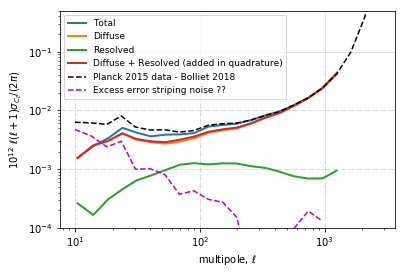

In [38]:
err_tot=(1./((2.*lbin+1.)*mtot.deltaell_bin*fsky_tot_apo))
err_tot=1e12*np.sqrt(err_tot*(m_milca_hm2_tot*m_nilc_hm1_tot + m_nilc_milca_tot**2.))

# err=(1./((2.*lbin+1.)*mtot.deltaell_bin*fsky_tot_apo))
# err=1e12*np.sqrt(err*(2.*m_nilc_milca_tot**2.))

err_diff=(1./((2.*lbin+1.)*mdiff.deltaell_bin*fsky_diff_apo))
err_diff=1e12*np.sqrt(err_diff*(m_milca_hm2_diff*m_nilc_hm1_diff + m_nilc_milca_diff**2.))

err_res=(1./((2.*lbin+1.)*mdiff.deltaell_bin*fsky_tot_apo))
err_res=1e12*np.sqrt(err_res*(m_milca_hm2_res*m_nilc_hm1_res + m_nilc_milca_res**2.))

figure()

plot(lbin,err_tot,lw=2,label="Total")
plot(lbin,err_diff,lw=2,label="Diffuse")
plot(lbin,err_res,lw=2,label="Resolved")
#plot(lbin,err,lw=2,label="Signal CV")
#plot(lbin,m_nilc_milca_tot*1e12,lw=2,label="Signal")
plot(lbin,np.sqrt(err_res**2. + err_diff**2.),lw=2,label="Diffuse + Resolved (added in quadrature)")
plot(planck_yy[:,0],planck_yy[:,2],"k--",label="Planck 2015 data - Bolliet 2018")
plot(planck_yy[:19,0],planck_yy[:19,2]-err_tot,"m--",label="Excess error striping noise ??")
xlabel(r"multipole, $\ell$")
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)\sigma_{C_{\ell}}/(2 \pi)$")
grid(alpha=0.6,linestyle="dashed")
loglog()
ylim(1e-4,5e-1)
legend(loc=0,fontsize=9)
figname=figpath + "error_estimates.pdf"
savefig(figname,bbox_inches="tight")

# Write data

In [23]:
filename=figpath + "total_yy_spec.txt"
title_str="# Total yy-spectrum"
fsky_str="# fsky=" + str(round(fsky_tot,3)) + " ; effective_fsky=" + str(round(fsky_tot_apo,3))
f=open(filename,"wb")
f.write("%-s \n" % title_str)
f.write("%-s \n" % "# Flags: SNR>=0. & COSMO=F ")
f.write("%-s \n \n" % fsky_str)
f.write("%-15s %-15s %-15s %-15s %-15s \n \n" % ("# lmin","lmax", "ell_eff","Dlyy*1e12","err_Dlyy*1e12 (Gauss)"))
for i in range(np.size(lbin)):
    f.write("%-15.8f %-15.8f %-15.8f %-15.8f %-15.8f\n" % (mtot.bmin[i],mtot.bmax[i],lbin[i],m_nilc_milca_tot[i]*1e12,err_tot[i]))
f.close()
tot=loadtxt(filename)

filename=figpath + "unresolved_yy_spec.txt"
title_str="# Un-resolved yy-spectrum"
fsky_str="# fsky=" + str(round(fsky_diff,3)) + " ; effective_fsky=" + str(round(fsky_diff_apo,3))
f=open(filename,"wb")
f.write("%-s \n" % title_str)
f.write("%-s \n" % "# Flags: COMPLEMENT(SNR>=6. & COSMO=T)")
f.write("%-s \n \n" % fsky_str)
f.write("%-15s %-15s %-15s %-15s %-15s \n \n" % ("# lmin", "lmax", "ell_eff","Dlyy*1e12","err_Dlyy*1e12 (Gauss)"))
for i in range(np.size(lbin)):
    f.write("%-15.8f %-15.8f %-15.8f %-15.8f %-15.8f\n" % (mtot.bmin[i],mtot.bmax[i],lbin[i],m_nilc_milca_diff[i]*1e12,err_diff[i]))
f.close()
diff=loadtxt(filename)

filename=figpath + "resolved_yy_spec.txt"
title_str="# Resolved yy-spectrum"
fsky_str="# fsky=" + str(round(fsky_tot,3)) + " ; effective_fsky=" + str(round(fsky_tot_apo,3))
f=open(filename,"wb")
f.write("%-s \n" % title_str)
f.write("%-s \n" % "# Flags: (SNR>=6. & COSMO=T)")
f.write("%-s \n \n" % fsky_str)
f.write("%-15s %-15s %-15s %-15s %-15s \n \n" % ("# lmin", "lmax", "ell_eff","Dlyy*1e12","err_Dlyy*1e12 (Gauss)"))
for i in range(np.size(lbin)):
    f.write("%-15.8f %-15.8f %-15.8f %-15.8f %-15.8f\n" % (mtot.bmin[i],mtot.bmax[i],lbin[i],m_nilc_milca_res[i]*1e12,err_res[i]))
f.close()
res=loadtxt(filename)

In [24]:
# figure()
# plot(lbin,res[:,3])
# plot(lbin,m_nilc_milca_res*1e12,"--")

# figure()
# plot(lbin,diff[:,4])
# plot(lbin,err_diff,"--")
# loglog()

# Test master algorithm

[]

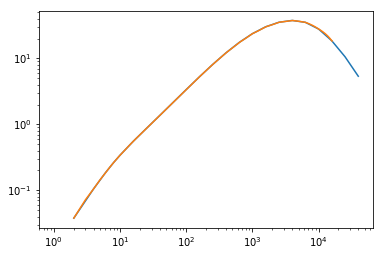

In [25]:
from scipy.interpolate import interp1d
d=loadtxt("../../../../Paper_plots/relativistic_sz/clyy/multipole_szpower_1e11_5e16.txt")
fn=interp1d(d[:,0],d[:,1])
ell=arange(15999,dtype="float") ; ell=ell+2.
clyy=fn(ell)
clyy=clyy*2.*pi/(ell*(ell+1.))
clyy=append(np.zeros(2,float),clyy)
ell=append(arange(2,dtype="float"),ell)

figure()
plot(d[:,0],d[:,1])
plot(ell,ell*(ell+1)*clyy/(2.*pi))
loglog()

In [53]:
lmax=int(max(mtot.bmax))
tmask=gal_ps_ccl_mask ; fsky=sum(tmask)/size(tmask)
#testcl=h.read_cl("../../../../../../Data/Planck/spectra/planck_wp_highL_lensing_param.fits")
testcl=clyy
beam=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=2000)*h.pixwin(nside)[:2001]
alm=h.synalm(testcl,lmax=2000,new=True)
alm=h.almxfl(alm,beam)
tmap=h.alm2map(alm,nside)
cltmap=h.alm2cl(h.map2alm(tmap*tmask,lmax=lmax))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [27]:
masklmax=2*nside
bl=np.copy(beam:lmax+1)
mres=bm.binned_master(tmask,2,lmax,masklmax,beam=bl,deltaell=20,bmin=bmin,bmax=bmax)

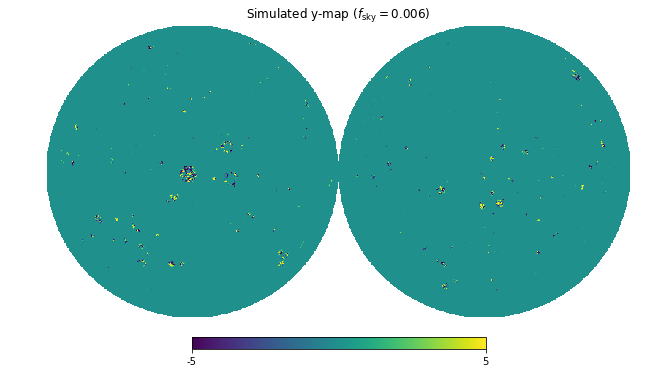

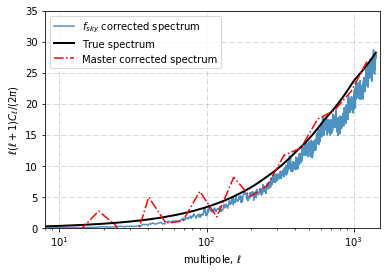

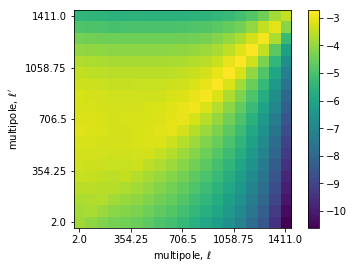

In [54]:
h.orthview(tmap*tmask,rot=(0,90),min=-5,max=5,title=r"Simulated y-map $(f_{\rm sky}=" + str(round(fsky,3)) + ")$")
figname=figpath + "simulated_masked_y_map_ccl.pdf"
savefig(figname,bbox_inches="tight")

lbin,mcl=mres.return_bmcs(cltmap)
ell=arange(lmax+1)
figure()
plot(ell,ell*(ell+1)*cltmap[:lmax+1]/(2.*pi*fsky*bl[:lmax+1]*bl[:lmax+1]),alpha=0.8,label=r"$f_{sky}$ corrected spectrum")
plot(ell,ell*(ell+1)*testcl[:lmax+1]/(2.*pi),"k-",lw=2,label="True spectrum")
plot(lbin,mcl,"r-.",label="Master corrected spectrum")
legend(loc=0)
grid(alpha=0.6,linestyle="dashed")
xlabel("multipole, $\ell$")
ylabel(r"$\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlim(8,1500)
ylim(4e-3,35)
semilogx()
#loglog()
figname=figpath + "test_master_ccl.pdf"
savefig(figname,bbox_inches="tight")

figure()
imshow(log10(mres.mbbp),origin="lower")
xlabel("multipole, $\ell$")
ylabel("multipole, $\ell'$")
figname=figpath + "coupling_matrix_ccl.pdf"
colorbar()
xticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
yticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
savefig(figname,bbox_inches="tight")

In [55]:
tmask=gal_ps_cl_mask ; fsky=sum(tmask)/size(tmask)
cltmap=h.alm2cl(h.map2alm(tmap*tmask,lmax=lmax,iter=5))

In [30]:
# masklmax=2*nside
# bl=np.copy(beam)
# mdiff=bm.binned_master(tmask,2,lmax,masklmax,beam=bl,deltaell=20,bmin=bmin,bmax=bmax)

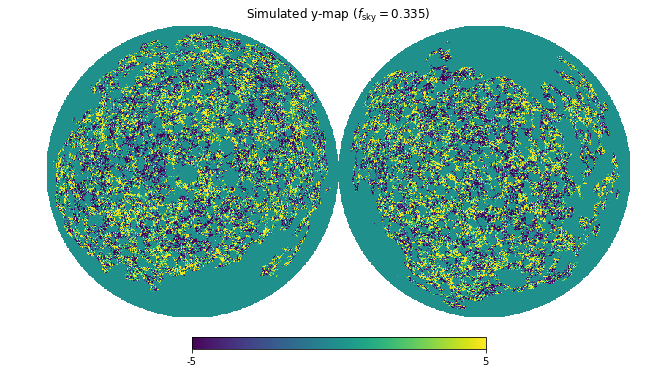

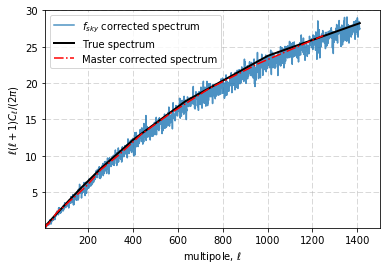

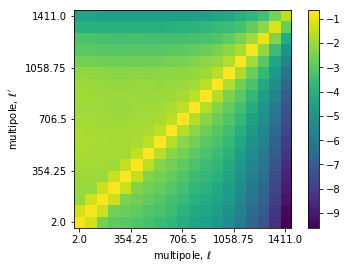

In [56]:
h.orthview(tmap*tmask,rot=(0,90),min=-5,max=5,title=r"Simulated y-map $(f_{\rm sky}=" + str(round(fsky,3)) + ")$")
figname=figpath + "simulated_masked_y_map_cl.pdf"
savefig(figname,bbox_inches="tight")

lbin,mcl=mdiff.return_bmcs(cltmap)
ell=arange(lmax+1)
figure()
plot(ell,ell*(ell+1)*cltmap[:lmax+1]/(2.*pi*fsky*bl[:lmax+1]*bl[:lmax+1]),alpha=0.8,label=r"$f_{sky}$ corrected spectrum")
plot(ell,ell*(ell+1)*testcl[:lmax+1]/(2.*pi),"k-",lw=2,label="True spectrum")
plot(lbin,mcl,"r-.",label="Master corrected spectrum")
legend(loc=0)
grid(alpha=0.6,linestyle="dashed")
xlabel("multipole, $\ell$")
ylabel(r"$\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlim(8,1500)
ylim(1e-1,30)
#loglog()
figname=figpath + "test_master_cl.pdf"
savefig(figname,bbox_inches="tight")

figure()
imshow(log10(mdiff.mbbp),origin="lower")
xlabel("multipole, $\ell$")
ylabel("multipole, $\ell'$")
figname=figpath + "coupling_matrix_cl.pdf"
colorbar()
xticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
yticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
savefig(figname,bbox_inches="tight")

# Theory

In [188]:
dtot=loadtxt("../../../../Paper_plots/relativistic_sz/clyy/multipole_szpower_1e11_5e15.txt")
dhm=loadtxt("../../../../Paper_plots/relativistic_sz/clyy/multipole_szpower_5e14_5e15.txt")

<IPython.core.display.Javascript object>


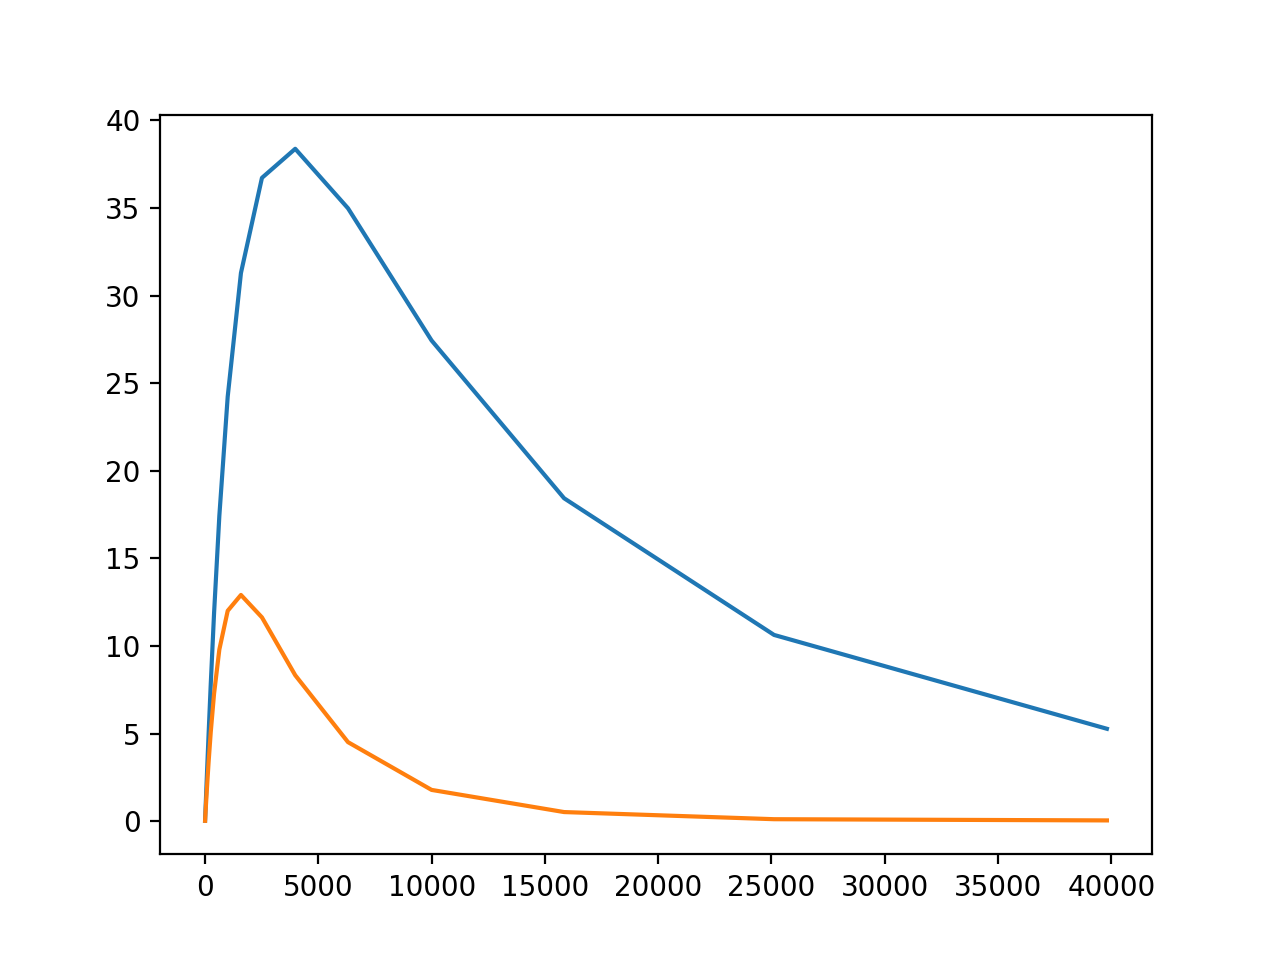

<IPython.core.display.Javascript object>


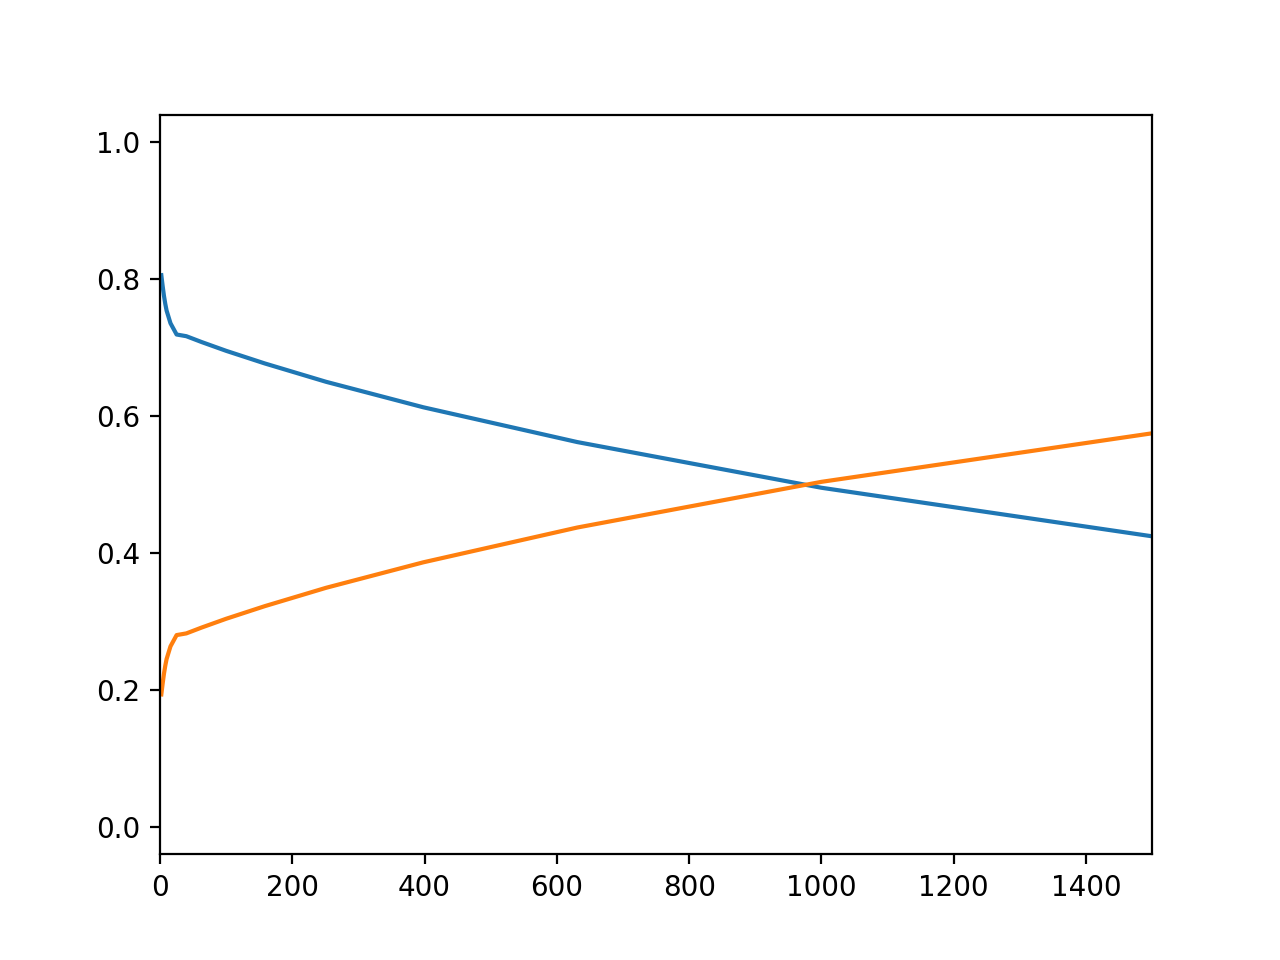

(0, 1500)

In [194]:
figure()
plot(dtot[:,0],dtot[:,1])
plot(dhm[:,0],dhm[:,1])

figure()
plot(dhm[:,0],dhm[:,1]/dtot[:,1])
plot(dhm[:,0],(dtot[:,1]-dhm[:,1])/dtot[:,1])
xlim(0,1500)